## Exploratory Data Analysis

In [1]:
import findspark
import pandas as pd
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkConf

# for shared metastore (shared across all users)
spark = SparkSession.builder.appName("List available databases and tables").config("hive.metastore.uris", "thrift://bialobog:9083", conf=SparkConf()).getOrCreate() \

# for local metastore (your private, invidivual database) add the following config to spark session

spark.catalog.listDatabases()

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/opt/hadoop-3.2.2/share/hadoop/common/lib/slf4j-log4j12-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/opt/apache-hive-2.3.7-bin/lib/log4j-slf4j-impl-2.6.2.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
2024-02-06 13:48:32,925 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2024-02-06 13:48:35,874 WARN spark.ExecutorAllocationManager: Dynamic allocation without a shuffle service is an experimental feature.


[Database(name='2023_11_01', description='FactSet data snapshot for 2023_11_01', locationUri='hdfs://amok.cs.ucl.ac.uk:8020/user/hive/warehouse/2023_11_01'),
 Database(name='2023_11_02', description='FactSet data snapshot for 2023_11_02', locationUri='hdfs://amok.cs.ucl.ac.uk:8020/user/hive/warehouse/2023_11_02'),
 Database(name='2023_11_03', description='FactSet data snapshot for 2023_11_03', locationUri='hdfs://amok.cs.ucl.ac.uk:8020/user/hive/warehouse/2023_11_03'),
 Database(name='2023_11_14', description='FactSet data snapshot for 2023_11_14', locationUri='hdfs://amok.cs.ucl.ac.uk:8020/user/hive/warehouse/2023_11_14'),
 Database(name='2023_11_19', description='FactSet data snapshot for 2023_11_19', locationUri='hdfs://amok.cs.ucl.ac.uk:8020/user/hive/warehouse/2023_11_19'),
 Database(name='2023_11_22', description='FactSet data snapshot for 2023_11_22', locationUri='hdfs://amok.cs.ucl.ac.uk:8020/user/hive/warehouse/2023_11_22'),
 Database(name='2024_01_25', description='FactSet da

In [2]:
from pyspark.sql.functions import regexp_replace
from pyspark.sql import functions as F

spark.sql("USE 2023_11_02")


DataFrame[]

#### Helper Functions

In [3]:
from pyspark.sql.functions import when
from datetime import datetime, timedelta

def get_all_stocks_df():
    query = f"""SELECT s.ticker_region, s.fsym_id FROM sym_ticker_region s 
                LEFT JOIN FF_SEC_COVERAGE c ON c.fsym_id = s.fsym_id
                LEFT JOIN sym_coverage sc ON sc.fsym_id = s.fsym_id
                WHERE s.ticker_region LIKE "%-US" AND s.ticker_region NOT LIKE '%.%' AND c.CURRENCY = "USD"
                AND (sc.fref_listing_exchange = "NAS" OR sc.fref_listing_exchange = "NYS")"""
    df = spark.sql(query)
    df = df.withColumn("ticker_region", regexp_replace("ticker_region", "-US$", ""))
    return df


def get_not_null_cols(df, table='FF_ADVANCED_DER_AF'):
    df=spark.createDataFrame(df)
    df.createOrReplaceTempView("temp_table")
    query1 = f"""SELECT t.fsym_id AS fsym_id2, a.*
                FROM temp_table t
                LEFT JOIN {table} a ON t.fsym_id = a.fsym_id
                WHERE a.date > '2000-01-01'
                ORDER BY t.fsym_id, a.date
            """
    #we get all the available dates per stock, so these null values are only within the timeframe available
    q_df = spark.sql(query1)
    q_df = q_df.drop('date', 'adjdate', 'fsym_id2', 'fsym_id')
    num_rows = q_df.count()
    column_types = q_df.dtypes
    good_cols = []
    selected_columns = [F.col(c) for c, c_type in zip(q_df.columns, column_types) if c_type[1] == 'double']
    q_df = q_df.select(selected_columns)
    count_df = q_df.select( [(F.count(F.when(F.isnan(c) | F.col(c).isNull(), c))/num_rows).alias(c) for c in q_df.columns])
    count_dict = count_df.first().asDict()
    filtered_keys = [key for key, value in count_dict.items() if value <= 0.25]
    return filtered_keys
#     for c, c_type in zip(q_df.columns, column_types):
#         if c_type[1] == 'double':
#             null_count = F.sum(F.when(F.isnan(F.col(c)) | F.col(c).isNull(), 1).otherwise(0))
#             null_pct = (null_count / num_rows).alias(f"{c}_null_pct")
#             q_df_agg = q_df.agg(null_pct)
#             actual_pct = q_df_agg.collect()[0][0]
#             if actual_pct < 0.25:
#                 good_cols.append(c)
            
#     return good_cols


def write_features_file(data_list, csv_file_path='features.csv'):
    data_list = [data_list]
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        for row in data_list:
            writer.writerow(row)
    print("Features written: ", data_list[0])



In [4]:
from CreateDataset import get_tabular_dataset, get_feature_col_names, get_not_null_cols
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import when, lit, col
# import pyspark.pandas as ps
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import csv
from sklearn.impute import SimpleImputer

def plot_nulls(df):
    null_counts = df.agg(*[
    (1 - (F.count(c) / F.count('*'))).alias(c + '_nulls') for c in df.columns])
    null_counts_pd = null_counts.toPandas().transpose()
    null_counts_pd.columns = ['null_percentage']

    # Plot the bar chart
    # null_counts_pd.plot(kind='bar', legend=False, figsize=(20, 6))
    # plt.title('Percentage of Null Values in Each Column')
    # plt.ylabel('Percentage of Null Values')
    # plt.xlabel('Columns')
    # plt.show()
    
def forward_fill(df):
    window_spec = Window.partitionBy('fsym_id').orderBy('date')
    feature_cols = df.columns[2:-1]
    for c in feature_cols:
        df = df.withColumn(
            c, F.last(c, ignorenulls=True).over(window_spec)
        )
    return df.orderBy('fsym_id','date')

def median_fill(df):
    window_spec = Window.partitionBy('fsym_id').orderBy('date')
    feature_cols = df.columns[2:-1]
    imputer = Imputer(strategy="median", inputCols=feature_cols, outputCols=feature_cols)
    
    
    
    for c in feature_cols:
        median_value = df.approxQuantile(c, [0.5], 0.001)[0]
        df = df.withColumn(
            c, F.when(F.col(c).isNull(), median_value).otherwise(F.col(c))
        )
    return df.orderBy('fsym_id','date')


def get_df(fn, all_feats=False, imploded_only=False, prediction=False):
    df = get_tabular_dataset(fn, all_feats=all_feats, imploded_only=imploded_only, prediction=prediction, null_thresh=0.2)
    print("df retrieved")
    
    # null_counts_per_column = df.select([col(c).isNull().cast("int").alias(c) for c in df.columns])
    # total_nulls = null_counts_per_column.agg(*[F.sum(col(c)).alias(c) for c in null_counts_per_column.columns]).collect()
    # print(total_nulls)
    # df = forward_fill(df)
    # print("done ffill")
    # null_counts_per_column = df.select([col(c).isNull().cast("int").alias(c) for c in df.columns])
    # total_nulls = null_counts_per_column.agg(*[F.sum(col(c)).alias(c) for c in null_counts_per_column.columns]).collect()
    # print(total_nulls)
    # print("Number of rows: ", df.count())
    # print("Number of positives: ", df.filter(F.col('label')==1).count())
    # plot_nulls(df)
    # df=df.fillna(0.0)
    # print("Number of rows after dropping nulls: ", df.count())
    # print("Number of positives after dropping nulls: ", df.filter(F.col('label')==1).count())
    # window_spec = Window.partitionBy('fsym_id')
    # feats = df.columns[2:-1]
    
    df =df.toPandas()
    # print(df.head(30))
#     feats = df.columns[2:-1]
#     for fsym_id, group in df.groupby('fsym_id'):
#         for col in group.columns[2:-1]:
#             group[col] = group[col].fillna(group[col].median())
    
#     print(df.head(10))
    # feats = df.columns[2:-1]
    # df[feats] = df.groupby('fsym_id')[feats].transform(lambda x: x.fillna(x.median()))
    # print(df.head(30))
    return df
    
def write_features_file(data_list, csv_file_path='features.csv'):
    data_list = [data_list]
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        for row in data_list:
            writer.writerow(row)
    print("Features written: ", data_list[0])

# df = get_df('imploded_stocks_price.csv')
df = get_df('imploded_stocks_price.csv', all_feats =True, prediction=False, imploded_only=False)
# plot_nulls(df)


/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
2024-02-06 13:49:02,645 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


['ff_assets_com_eq', 'ff_assets_eq', 'ff_assets_gr', 'ff_assets_oth_tot', 'ff_assets_per_emp', 'ff_bps_gr', 'ff_capex_assets', 'ff_capex_ps_cf', 'ff_cash_div_cf', 'ff_cash_roce', 'ff_cf_ps_gr', 'ff_cf_sales', 'ff_com_eq_gr', 'ff_com_eq_tcap', 'ff_debt_com_eq', 'ff_debt_entrpr_val', 'ff_debt_eq', 'ff_debt_lt_cf', 'ff_debt_st_x_curr_port', 'ff_dfd_tax_assets_lt', 'ff_dil_adj', 'ff_div_yld', 'ff_div_yld_secs', 'ff_earn_yld', 'ff_ebit_oper_roa', 'ff_entrpr_val_sales', 'ff_eps_basic_gr', 'ff_fix_assets_com_eq', 'ff_for_assets_pct', 'ff_for_sales_pct', 'ff_free_ps_cf', 'ff_gross_cf_debt', 'ff_inc_adj', 'ff_inc_sund', 'ff_inc_tax_curr', 'ff_inc_tax_dfd', 'ff_int_exp_oth', 'ff_invest_cap', 'ff_invest_lt', 'ff_invest_st_tot', 'ff_ltd_com_eq', 'ff_ltd_tcap', 'ff_min_int_tcap', 'ff_net_cf_debt', 'ff_net_inc_basic_aft_xord', 'ff_net_inc_basic_beft_xord', 'ff_net_inc_bef_xord_gr', 'ff_net_inc_dil', 'ff_net_inc_dil_aft_xord', 'ff_net_inc_per_emp', 'ff_non_oper_exp', 'ff_oper_cf_fix_chrg', 'ff_oper_i

In [5]:
# df2 = median_fill(df2)

In [6]:
df.count()

fsym_id              114405
date                 114405
ff_assets_com_eq     104429
ff_assets_eq         112790
ff_assets_gr         106059
                      ...  
ff_fcf_yld            94006
GDP                  114405
Unemployment_Rate    114405
CPI                  114405
label                114405
Length: 95, dtype: int64

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


def correlation_matrix(df):
    # df =df.toPandas()
    print("Converted to Pandas")
    corr_df = df.drop(['date','fsym_id'], axis=1)
    corr_mat = corr_df.corr().abs()
    mask = np.triu(np.ones_like(corr_mat))
    plt.figure(figsize=(50, 40))
    sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
    plt.title('Correlation Matrix Heatmap')
    plt.tight_layout()
    plt.savefig('corr_matrix_tab.png')
    plt.close()
    
    print("Variable pairs with absolute correlation above 0.7:")
    corr_dict = {}
    for i in range(len(corr_mat.columns)):
        for j in range(i+1, len(corr_mat.columns)):
            if abs(corr_mat.iloc[i, j]) >= 0.7:
                print(f"{corr_mat.columns[i]} - {corr_mat.columns[j]}: {corr_mat.iloc[i, j]}")
                if corr_mat.columns[i] not in corr_dict.keys():
                    corr_dict[corr_mat.columns[i]] = [corr_mat.columns[j]]
                else:
                    corr_dict[corr_mat.columns[i]].append(corr_mat.columns[j])
                    
    for k,v in corr_dict.items():
        if len(corr_dict[k]) >= 1:
            for col in corr_dict[k]:
                if col in df.columns:
                    df=df.drop(col,axis=1)
    
                

    print(df.columns)
    return df

    
                
df=correlation_matrix(df) #pandas now
# df=correlation_matrix(df)

Converted to Pandas
Variable pairs with absolute correlation above 0.7:
ff_assets_com_eq - ff_assets_eq: 0.9978259695884077
ff_assets_com_eq - ff_debt_com_eq: 0.9987191563527388
ff_assets_com_eq - ff_debt_eq: 0.9977482671845153
ff_assets_com_eq - ff_fix_assets_com_eq: 0.7122343251185763
ff_assets_com_eq - ff_ltd_com_eq: 0.9986610776692398
ff_assets_eq - ff_debt_com_eq: 0.9997629980181031
ff_assets_eq - ff_debt_eq: 0.9955322986555307
ff_assets_eq - ff_fix_assets_com_eq: 0.7122733662103068
ff_assets_eq - ff_ltd_com_eq: 0.9997536704637969
ff_assets_gr - ff_com_eq_gr: 0.9999999946425574
ff_assets_gr - ff_debt_lt_cf: 0.998721272725722
ff_assets_gr - ff_debt_st_x_curr_port: 0.9583701208823773
ff_assets_gr - ff_inc_tax_curr: 0.9878410616827827
ff_assets_gr - ff_inc_tax_dfd: 0.966802689600184
ff_assets_gr - ff_int_exp_oth: 0.9979743820987891
ff_assets_gr - ff_invest_cap: 0.9985831218175397
ff_assets_gr - ff_net_inc_basic_aft_xord: 0.9981793555069817
ff_assets_gr - ff_net_inc_basic_beft_xord: 0

In [8]:

feats = df.columns[2:-1]
df[feats] = df.groupby('fsym_id')[feats].transform(lambda x : x.fillna(method='ffill'))
df[feats] = df.groupby('fsym_id')[feats].transform(lambda x: x.fillna(x.median()))


/opt/jupyterhub/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/jupyterhub/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [9]:
# df = df.drop('ff_debt_com_eq', 'ff_debt_eq', '' 'ff_div_yld_secs', 'ff_earn_yld', 'ff_roa_ptx', 'ff_net_inc_basic_aft_xord', 'ff_net_inc_dil', 'ff_oper_inc_aft_unusual', 
#                         'ff_net_inc_dil_aft_xord', 'ff_net_inc_dil_bef_unusual', 'ff_ebit_bef_unusual', 'ff_eps_dil_gr', 'GDP', 'ff_bk_oper_inc_tot')
feats = df.columns[2:-1]
# write_features_file(feats)
print(len(feats))

43


In [10]:
df.head()

,fsym_id,date,ff_assets_com_eq,ff_assets_gr,ff_assets_oth_tot,ff_assets_per_emp,ff_bps_gr,ff_capex_assets,ff_cash_div_cf,ff_cash_roce,...,ff_xord,ff_std_debt,ff_tang_assets_debt,ff_bk_oper_inc_oth,ff_commiss_inc_net,ff_cf_roic,ff_liabs_lease,GDP,Unemployment_Rate,label
0,B00FG1-R,2012-12-31,1.248053,7.348883,0.000,10.576109,56.030954,78.273974,0.000000,-32.48987,...,0.0,0.000000,129.518779,0.000000,0.000000,20.792882,0.0,0.006181,7.9,0
1,B00FG1-R,2013-12-31,1.016917,27.333701,0.000,10.576109,56.273777,38.851847,0.000000,-32.48987,...,0.0,0.000000,129.518779,0.000000,0.000000,-32.489870,0.0,0.014049,6.7,0
2,B00FG1-R,2014-12-31,1.016917,1213.345113,2.152,10.576109,-492.849757,11.984993,3321.316445,-32.48987,...,0.0,0.000000,77.245294,-0.294125,0.294125,3.610653,0.0,0.006058,5.6,0
3,B00FG1-R,2015-12-31,1.016917,7.348883,0.000,10.576109,-48.051855,0.483800,186.785493,-32.48987,...,0.0,0.000000,70.526570,-1.071870,1.071870,19.546902,0.0,0.001821,5.0,0
4,B00FG1-R,2016-12-31,1.016917,76.903869,0.000,10.576109,85.114102,2.179701,238.208140,-32.48987,...,0.0,6.938208,130.866314,-0.710952,0.710952,21.835781,0.0,0.010414,4.7,0


In [11]:
%%capture
import warnings
warnings.filterwarnings("ignore")
import tsfel

def feature_extraction(df):
    df = df.set_index('date')

    
    cfg = tsfel.get_features_by_domain("statistical")
    
    result_dfs = []
    for fsym_id, group_df in df.groupby('fsym_id'):
        # Exclude 'fsym_id' column from group_df
        # print(group_df.head())
        # non_zero_cols = group_df.columns[(group_df != 0).any()]
        # group_df = group_df[non_zero_cols]

        if not group_df.empty:
            try:
                X = tsfel.time_series_features_extractor(cfg, group_df.drop(['fsym_id', 'label'], axis=1), verbose=0)
                X['fsym_id'] = group_df['fsym_id'].iloc[0]
                X['label'] = group_df['label'].sum()
                result_dfs.append(X)
            except ValueError:
                continue
    
    final_result = pd.concat(result_dfs, ignore_index=True)
    final_result.reset_index(drop=True, inplace=True)
    return final_result

df = feature_extraction(df)

In [12]:
df.head()

,GDP_Absolute energy,GDP_Average power,GDP_ECDF Percentile Count_0,GDP_ECDF Percentile Count_1,GDP_ECDF Percentile_0,GDP_ECDF Percentile_1,GDP_ECDF_0,GDP_ECDF_1,GDP_ECDF_2,GDP_ECDF_3,...,ff_xord_Median,ff_xord_Median absolute deviation,ff_xord_Min,ff_xord_Peak to peak distance,ff_xord_Root mean square,ff_xord_Skewness,ff_xord_Standard deviation,ff_xord_Variance,fsym_id,label
0,0.002318,0.025761,2.0,8.0,0.005728,0.017409,0.100000,0.200000,0.300000,0.400000,...,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,B00FG1-R,0
1,0.001046,0.020922,1.0,4.0,0.005892,0.013815,0.166667,0.333333,0.500000,0.666667,...,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,B01DPB-R,0
2,0.004729,0.021496,4.0,18.0,0.005892,0.015917,0.043478,0.086957,0.130435,0.173913,...,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,B01HWF-R,0
3,0.003683,0.023019,3.0,13.0,0.005728,0.014049,0.058824,0.117647,0.176471,0.235294,...,0.0,0.0,-8.881784e-16,8.881784e-16,2.154149e-16,-3.75,2.089832e-16,4.367396e-32,B04CB3-R,0
4,0.004199,0.023328,3.0,15.0,0.005728,0.015917,0.052632,0.105263,0.157895,0.210526,...,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,B04HL7-R,0


In [13]:
# threshold = len(df2) * 0.9  # 20% of the rows
# df2.dropna(axis=1, thresh=threshold, inplace=True)
df.dropna(axis=1, inplace=True)

In [14]:
print(len(df.columns))
print(len(df))
print(len(df[df['label']==1]))

709
7916
386


In [15]:
feats = df.columns[:-2]

2024-02-06 14:06:32,647 WARN scheduler.TaskSetManager: Stage 22 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.


Number of records:  7916


2024-02-06 14:06:35,182 WARN scheduler.TaskSetManager: Stage 24 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.


{0: 0.5253112033195021, 1: 10.37704918032787}
[{}]                                                   
  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

2024-02-06 14:06:38,824 WARN scheduler.TaskSetManager: Stage 26 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:06:42,535 WARN scheduler.TaskSetManager: Stage 28 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:06:43,448 WARN scheduler.TaskSetManager: Stage 29 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:06:44,721 WARN scheduler.TaskSetManager: Stage 30 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:06:46,133 WARN scheduler.TaskSetManager: Stage 32 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:06:46,876 WARN scheduler.TaskSetManager: Stage 34 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:06:47,304 WARN scheduler.TaskSetManage

[{}]                                                                                
  1%|          | 1/100 [01:31<2:31:42, 91.94s/trial, best loss: -0.9999568585434192]

2024-02-06 14:08:10,435 WARN scheduler.TaskSetManager: Stage 458 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:08:11,388 WARN scheduler.TaskSetManager: Stage 460 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:08:11,503 WARN scheduler.TaskSetManager: Stage 461 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:08:11,761 WARN scheduler.TaskSetManager: Stage 462 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:08:12,238 WARN scheduler.TaskSetManager: Stage 464 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:08:12,540 WARN scheduler.TaskSetManager: Stage 466 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:08:12,811 WARN scheduler.TaskSet

[{}]                                                                                
  2%|▏         | 2/100 [02:51<2:17:59, 84.49s/trial, best loss: -0.9999568585434192]

2024-02-06 14:09:29,738 WARN scheduler.TaskSetManager: Stage 878 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:09:30,559 WARN scheduler.TaskSetManager: Stage 880 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:09:30,619 WARN scheduler.TaskSetManager: Stage 881 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:09:30,807 WARN scheduler.TaskSetManager: Stage 882 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:09:31,339 WARN scheduler.TaskSetManager: Stage 884 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:09:31,676 WARN scheduler.TaskSetManager: Stage 886 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:09:31,933 WARN scheduler.TaskSet

[{}]                                                                                
  3%|▎         | 3/100 [04:13<2:14:49, 83.39s/trial, best loss: -0.9999568585434192]

2024-02-06 14:10:51,805 WARN scheduler.TaskSetManager: Stage 1322 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:10:52,527 WARN scheduler.TaskSetManager: Stage 1324 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:10:52,590 WARN scheduler.TaskSetManager: Stage 1325 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:10:52,792 WARN scheduler.TaskSetManager: Stage 1326 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:10:53,236 WARN scheduler.TaskSetManager: Stage 1328 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:10:53,514 WARN scheduler.TaskSetManager: Stage 1330 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:10:53,738 WARN scheduler.T

[{}]                                                                                
  4%|▍         | 4/100 [05:29<2:08:50, 80.53s/trial, best loss: -0.9999568585434192]

2024-02-06 14:12:07,909 WARN scheduler.TaskSetManager: Stage 1742 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:12:08,583 WARN scheduler.TaskSetManager: Stage 1744 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:12:08,650 WARN scheduler.TaskSetManager: Stage 1745 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:12:08,853 WARN scheduler.TaskSetManager: Stage 1746 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:12:09,312 WARN scheduler.TaskSetManager: Stage 1748 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:12:09,606 WARN scheduler.TaskSetManager: Stage 1750 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:12:09,853 WARN scheduler.T

[{}]                                                                                
  5%|▌         | 5/100 [06:53<2:09:32, 81.81s/trial, best loss: -0.999978605564438]

2024-02-06 14:13:31,949 WARN scheduler.TaskSetManager: Stage 2210 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:13:32,670 WARN scheduler.TaskSetManager: Stage 2212 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:13:32,735 WARN scheduler.TaskSetManager: Stage 2213 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:13:32,964 WARN scheduler.TaskSetManager: Stage 2214 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:13:33,482 WARN scheduler.TaskSetManager: Stage 2216 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:13:33,786 WARN scheduler.TaskSetManager: Stage 2218 contains a task of very large size (4180 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:13:34,058 WARN scheduler.T

[{}]                                                                               
  6%|▌         | 6/100 [08:12<2:06:41, 80.86s/trial, best loss: -0.999978605564438]

2024-02-06 14:14:50,946 WARN scheduler.TaskSetManager: Stage 2630 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:14:51,693 WARN scheduler.TaskSetManager: Stage 2632 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:14:51,775 WARN scheduler.TaskSetManager: Stage 2633 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:14:51,971 WARN scheduler.TaskSetManager: Stage 2634 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:14:52,437 WARN scheduler.TaskSetManager: Stage 2636 contains a task of very large size (4180 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:14:52,775 WARN scheduler.TaskSetManager: Stage 2638 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:14:53,080 WARN scheduler.T

[{}]                                                                               
  7%|▋         | 7/100 [09:38<2:07:45, 82.42s/trial, best loss: -0.999978605564438]

2024-02-06 14:16:16,779 WARN scheduler.TaskSetManager: Stage 3098 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:16:17,474 WARN scheduler.TaskSetManager: Stage 3100 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:16:17,542 WARN scheduler.TaskSetManager: Stage 3101 contains a task of very large size (4180 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:16:17,745 WARN scheduler.TaskSetManager: Stage 3102 contains a task of very large size (4180 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:16:18,212 WARN scheduler.TaskSetManager: Stage 3104 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:16:18,496 WARN scheduler.TaskSetManager: Stage 3106 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:16:18,751 WARN scheduler.T

  8%|▊         | 8/100 [10:56<2:04:10, 80.98s/trial, best loss: -0.999978605564438]

[{}]                                                                               
  8%|▊         | 8/100 [10:56<2:04:10, 80.98s/trial, best loss: -0.999978605564438]

2024-02-06 14:17:34,624 WARN scheduler.TaskSetManager: Stage 3530 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:17:35,260 WARN scheduler.TaskSetManager: Stage 3532 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:17:35,322 WARN scheduler.TaskSetManager: Stage 3533 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:17:35,504 WARN scheduler.TaskSetManager: Stage 3534 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:17:35,964 WARN scheduler.TaskSetManager: Stage 3536 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:17:36,249 WARN scheduler.TaskSetManager: Stage 3538 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:17:36,503 WARN scheduler.T

[{}]                                                                               
  9%|▉         | 9/100 [12:13<2:00:58, 79.77s/trial, best loss: -0.999978605564438]

2024-02-06 14:18:51,569 WARN scheduler.TaskSetManager: Stage 3938 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:18:52,246 WARN scheduler.TaskSetManager: Stage 3940 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:18:52,314 WARN scheduler.TaskSetManager: Stage 3941 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:18:52,522 WARN scheduler.TaskSetManager: Stage 3942 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:18:52,975 WARN scheduler.TaskSetManager: Stage 3944 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:18:53,327 WARN scheduler.TaskSetManager: Stage 3946 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:18:53,615 WARN scheduler.T

 10%|█         | 10/100 [13:28<2:01:19, 80.88s/trial, best loss: -0.999978605564438]
Best hyperparameters:  {'maxBins': 19.0, 'maxDepth': 29.0}
[{}]


2024-02-06 14:20:07,267 WARN scheduler.TaskSetManager: Stage 4346 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:20:08,121 WARN scheduler.TaskSetManager: Stage 4348 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:20:08,174 WARN scheduler.TaskSetManager: Stage 4349 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:20:08,372 WARN scheduler.TaskSetManager: Stage 4350 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:20:08,854 WARN scheduler.TaskSetManager: Stage 4352 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:20:09,138 WARN scheduler.TaskSetManager: Stage 4354 contains a task of very large size (4130 KiB). The maximum recommended task size is 1000 KiB.
2024-02-06 14:20:09,422 WARN scheduler.T

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1505
           1       0.93      0.31      0.46        81

    accuracy                           0.96      1586
   macro avg       0.95      0.65      0.72      1586
weighted avg       0.96      0.96      0.95      1586

MCC:  0.5229821344548174


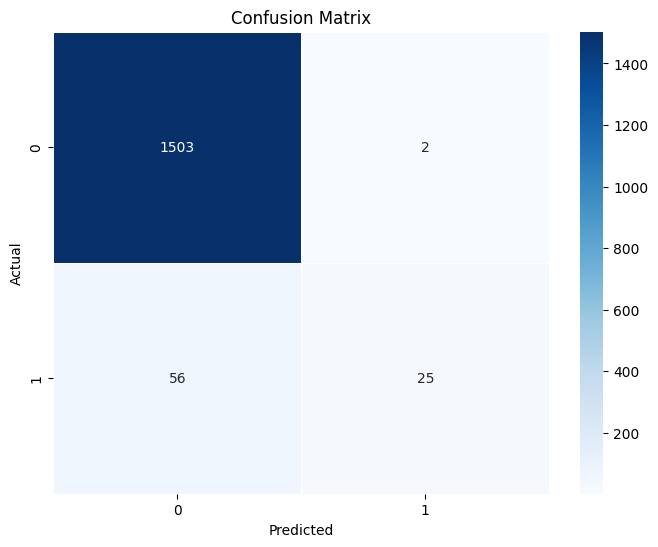

In [16]:
from hyperopt import fmin, tpe, hp
import csv
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from itertools import chain
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from hyperopt.early_stop import no_progress_loss
from sklearn.metrics import matthews_corrcoef


# Suppress warnings for this cell


def t_t_split(df):
    train, test = df.randomSplit([0.8,0.2])
    return train, test


def feature_importances(model, features, name):
    feature_importances = model.featureImportances.toArray()
    

    top_features_idx = np.argsort(feature_importances)[-25:]  # Get the indices of the top 25 features
    sorted_features = [features[i] for i in top_features_idx]


    plt.figure(figsize=(20, 6))
    plt.bar(range(len(sorted_features)), feature_importances[top_features_idx], align="center")
    plt.xticks(range(len(sorted_features)), sorted_features, rotation=45, ha="right")
    plt.xlabel("Feature")
    plt.ylabel("Feature Importance")
    plt.title("Feature Importances")
    plt.savefig(f'{name}_if_feats.png', bbox_inches='tight')
    return sorted_features
    
    
def model_training_spark(df, classifier):
    
    print("Number of records: ", df.count())
    
    features = df.columns[:-2]
    
    train_df, test_df = t_t_split(df)
    
        
    def compute_weights(train_df):
        y_collect = train_df.select("label").groupBy("label").count().collect()
        unique_y = [x["label"] for x in y_collect]
        total_y = sum([x["count"] for x in y_collect])
        unique_y_count = len(y_collect)
        bin_count = [x["count"] for x in y_collect]

        class_weights_spark = {i: ii for i, ii in zip(unique_y, total_y / (unique_y_count * np.array(bin_count)))}
        print(class_weights_spark)
        mapping_expr = F.create_map([F.lit(x) for x in chain(*class_weights_spark.items())])
        train_df = train_df.withColumn("weight", mapping_expr.getItem(F.col("label")))
        return train_df
        
    train_df = compute_weights(train_df)
    
    vector_assembler = VectorAssembler(inputCols=features, outputCol="features_vector")
    train_df = vector_assembler.transform(train_df)
    test_df = vector_assembler.transform(test_df)

    if classifier == 'LogisticRegression':
        param_space = {
            'regParam': hp.uniform('regParam', 0.01, 1.0),
            'elasticNetParam': hp.uniform('elasticNetParam', 0.0, 1.0)
        }
        classifier_instance = LogisticRegression(featuresCol="features_vector", labelCol="label", weightCol='weight')
    elif classifier == 'RandomForest':
        param_space = {
            'maxBins': hp.quniform('maxBins', 16, 32, 1),
            'maxDepth': hp.quniform('maxDepth', 20, 30, 1)
        }
        classifier_instance = RandomForestClassifier(featuresCol='features_vector', labelCol='label', weightCol='weight')
    elif classifier == 'GBT':
        param_space = {
            'maxDepth' : hp.quniform("maxDepth", 3, 18, 1),
            'maxBins': hp.quniform('maxBins', 16, 32, 1)
        }
        classifier_instance = GBTClassifier(featuresCol='features_vector', labelCol='label')
    else:
        raise ValueError("Unsupported classifier")
    
    # initial_model = classifier_instance
    # initial_model = initial_model.fit(train_df)

    def cross_val_train(params):
        classifier_instance.setParams(**params)
        evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')
        # train, val = train_df.randomSplit([0.9,0.1])
        # curr_model = classifier_instance.fit(train)
        # predictions = curr_model.transform(val)
        # val_metric = evaluator.evaluate(predictions)
        # return curr_model, val_metric
        paramGrid = ParamGridBuilder().build()
        print(paramGrid)
        crossval = CrossValidator(estimator=classifier_instance,
                                  estimatorParamMaps=paramGrid,
                                  evaluator=evaluator,
                                  numFolds=5, parallelism=12)
        
        cv_model = crossval.fit(train_df)
        predictions = cv_model.transform(train_df)
        val_metric = evaluator.evaluate(predictions)
        return cv_model.bestModel, val_metric
    
    
    def objective(params):
        model, metric = cross_val_train(params)
        return -metric

    # Find the best hyperparameters
    best_params = fmin(fn=objective, space=param_space, algo=tpe.suggest, max_evals=100, early_stop_fn=no_progress_loss(5))
    print("Best hyperparameters: ", best_params)

    # Train the model with the best hyperparameters
    best_model, final_metric = cross_val_train(best_params)
            
    
    predictions = best_model.transform(test_df)
    true = predictions.select('label').toPandas()
    preds = predictions.select('prediction').toPandas()
    print(classification_report(true, preds))
    print("MCC: ", matthews_corrcoef(true, preds))
    
    with open(f'classification_report_{classifier}.txt', 'w') as f:
        f.write(classification_report(true, preds))
        f.write(f"\n\nMatthews Correlation Coefficient: {matthews_corrcoef(true, preds)}")
    
    cm = confusion_matrix(true, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    return best_model, train_df, test_df, predictions

df = spark.createDataFrame(df)
model, train_df, test_df, pred_df = model_training_spark(df, 'RandomForest')

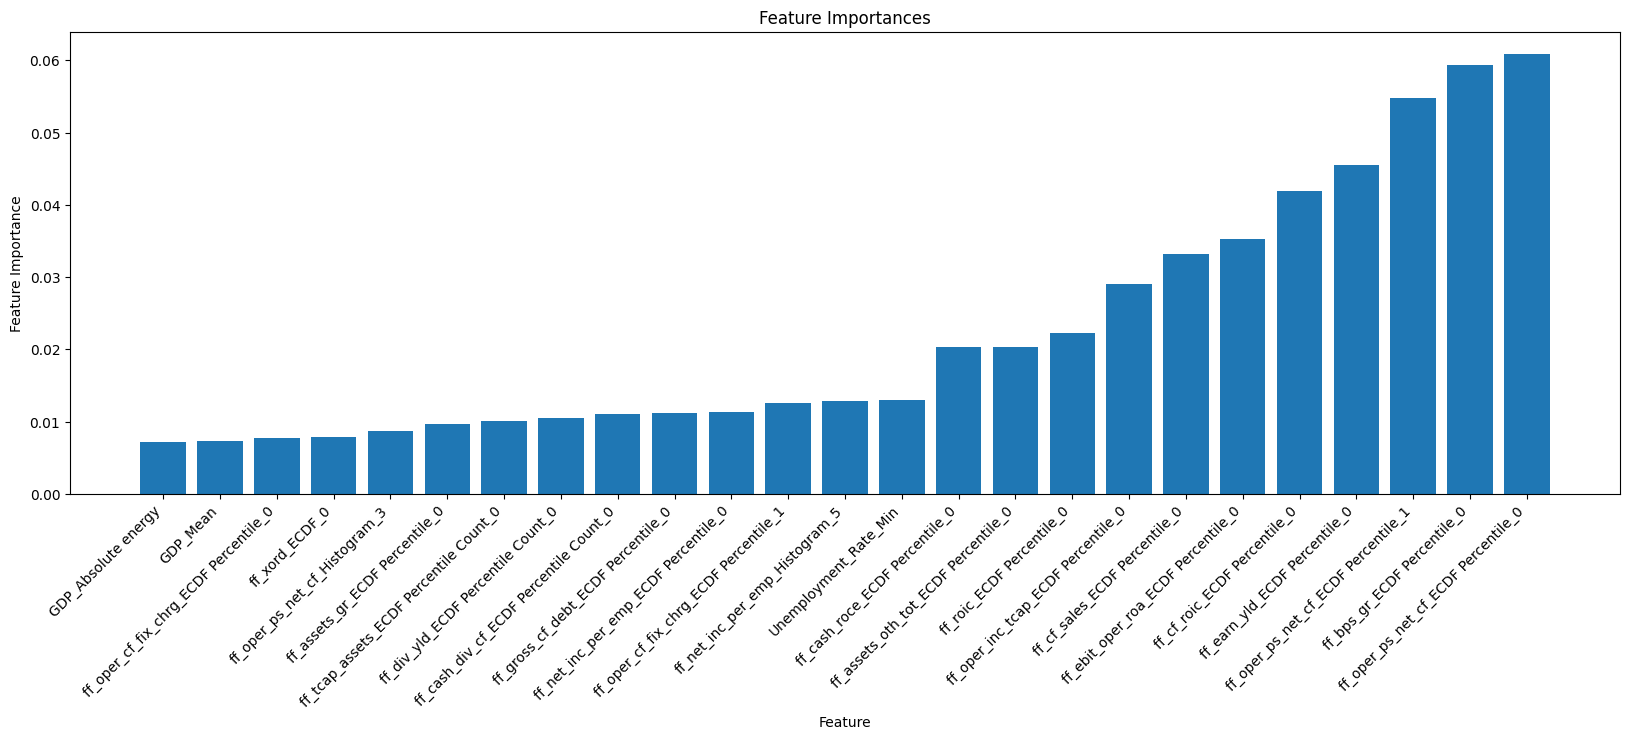

In [17]:
top_feats = feature_importances(model,feats, 'RandomForest')

df2 = df.select(*top_feats, 'fsym_id', 'label')
# df2 = df.drop(*feats_to_drop)

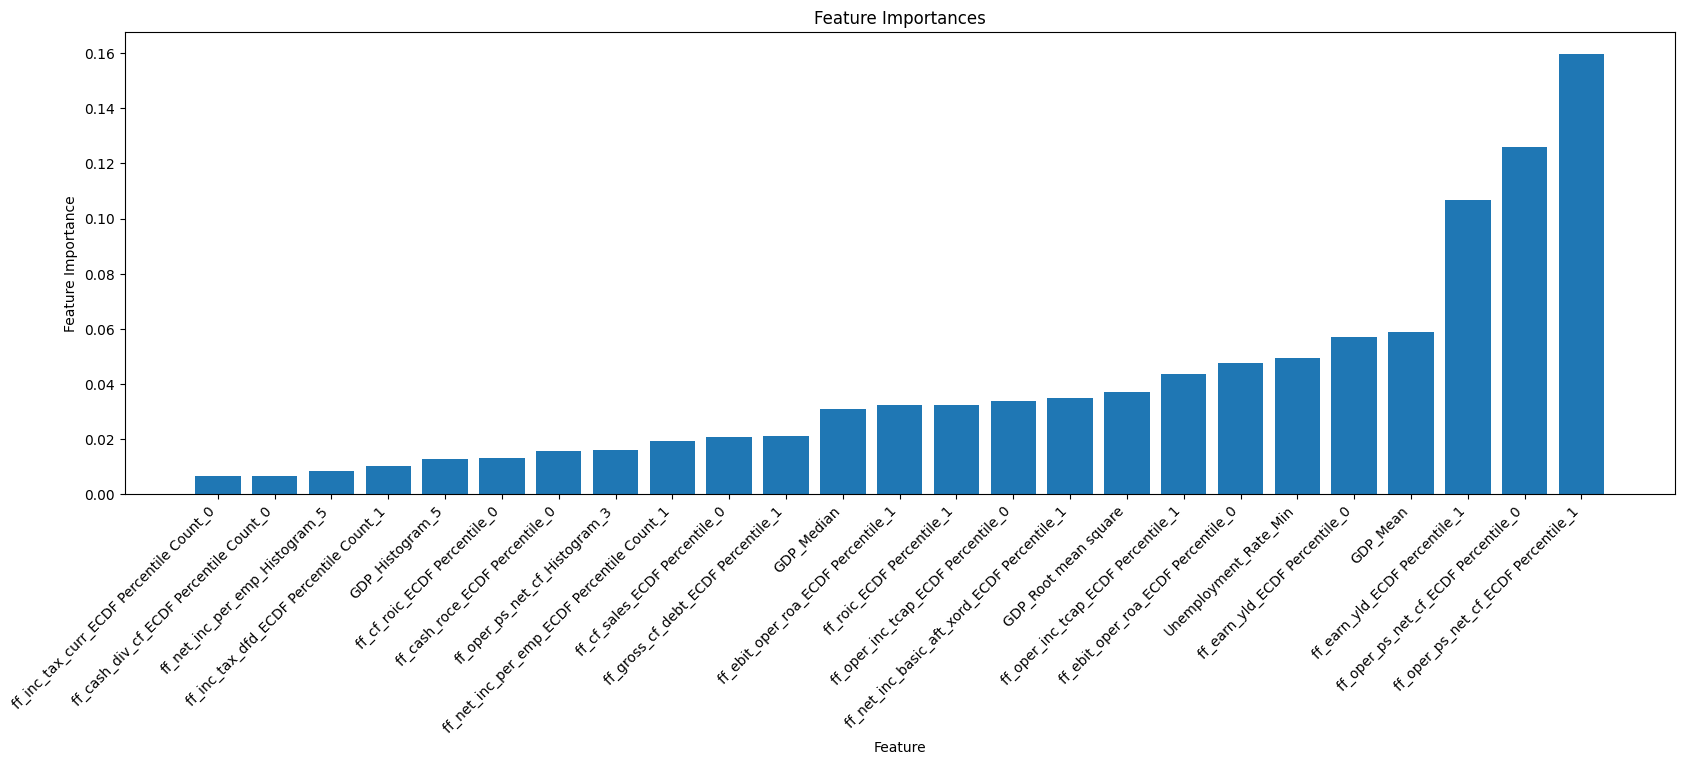

In [68]:
# model2, feats2, X_train2 = model_training_spark(df2, 'RandomForest')
_ = feature_importances(model2,top_feats)

In [76]:
from sklearn.ensemble import IsolationForest

def anomaly_det(df):
    
    seed = 42
    train_df, test_df = t_t_split(df)
    train_df = train_df.toPandas()
    test_df = test_df.toPandas()
    print("Converted to Pandas")
    exclude_columns = ['fsym_id', 'label']
    
    
    features =train_df.columns[:-2]
    print(len(features))
    
    num_pos = len(train_df[train_df['label']==1])
    print(num_pos/len(train_df))
    isol_for = IsolationForest(contamination=num_pos/len(train_df), random_state=42)
    
    isol_for.fit(train_df[features])

    train_df['anomaly_scores'] = isol_for.decision_function(train_df[features])
    train_df['anomaly'] = isol_for.predict(train_df[features])
    train_df['preds'] = np.where(train_df['anomaly'] == 1, 0, 1)

    test_df['anomaly_scores'] = isol_for.decision_function(test_df[features])
    test_df['anomaly'] = isol_for.predict(test_df[features])
    test_df['preds'] = np.where(test_df['anomaly'] == 1, 0, 1)
    
    print(f"Classification Report: ")
    print(classification_report(test_df['label'], test_df['preds']))
    return test_df
    
    
test_df_isol = anomaly_det(df2)

2024-02-03 17:41:22,342 WARN scheduler.TaskSetManager: Stage 25591 contains a task of very large size (32703 KiB). The maximum recommended task size is 1000 KiB.
2024-02-03 17:41:23,763 WARN scheduler.TaskSetManager: Stage 25592 contains a task of very large size (32703 KiB). The maximum recommended task size is 1000 KiB.


Converted to Pandas
25
0.06355109961190168
Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1537
           1       0.46      0.43      0.44       111

    accuracy                           0.93      1648
   macro avg       0.71      0.70      0.70      1648
weighted avg       0.93      0.93      0.93      1648



In [92]:
from CreateDataset import get_fund_data
import math

def plotting_stocks_pandas(df):
    imploded_stocks = df[(df['label'] == 1) & (df['preds'] == 0)]
    spark_df = spark.createDataFrame(imploded_stocks['fsym_id'].to_frame())
    imp_prices = get_fund_data(spark_df)
    
    adj_pd = imp_prices.toPandas()
    adj_pd['date'] = pd.to_datetime(adj_pd['date'])
    list_to_plot = sorted(adj_pd['fsym_id'].unique().tolist())
    
    columns = 8
    num_rows = math.ceil(len(list_to_plot) / columns)
    fig, axs = plt.subplots(nrows=num_rows, ncols=columns, figsize=(35, 5*num_rows))
    axs = axs.flatten()
    
    i = 0
    for t in list_to_plot:
        temp_df = adj_pd[adj_pd['fsym_id']==t]
        axs[i].plot(temp_df['date'], temp_df['adj_price'], label=t)

        axs[i].legend()
        #axs[i].text(0.5, -0.1, f'Volatility: {vol:.2f}', ha='center', transform=axs[i].transAxes)
        i+=1
        
    for i in range(len(list_to_plot), num_rows * columns):
        fig.delaxes(axs.flatten()[i])
    
        
    plt.tight_layout()
    plt.savefig('implosions_not_detected_by_model.png')
    
# print(len(test_df_isol[test_df_isol['preds']==1]))
# print(len(test_df_isol[test_df_isol['label']==1]))
# plotting_stocks_pandas(test_df_isol)   

In [13]:
from Boruta import BorutaPy
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


def boruta_fs(train_df, model_name): #HOW DOES BORUTA ACC WORK?
    train_df = train_df.toPandas()
    X_train = train_df.drop(['fsym_id', 'date', 'label'], axis=1)
    y_train = train_df['label']
    
    if model_name == 'rf':
        model = RandomForestClassifier()
    else:
        model = GradientBoostingClassifier
    feat_selector = BorutaPy(model, n_estimators='auto', verbose=1, random_state=1)
    feat_selector.fit(X_train, y_train)
    features = X_train.columns.tolist()
    print("Number of features: ", len(features) )
    feature_ranks = list(zip(features, feat_selector.ranking_, feat_selector.support_))
    selected_features = []
    for feat in feature_ranks:
        print(f"Feature: {feat[0]}, Rank: {feat[1]}, Keep: {feat[2]}")
        if feat[1] <= 5:
            selected_features.append(feat[0])
    print("Selected features: ", selected_features)
    return selected_features

rf_feats = boruta_fs(df, 'rf')
# gbt_feats = boruta_fs(df, 'gbt')

2024-01-22 23:11:31,816 WARN scheduler.TaskSetManager: Stage 114 contains a task of very large size (6064 KiB). The maximum recommended task size is 1000 KiB.


Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100


KeyboardInterrupt: 

### Investigating metrics that changed the most before and after implosions

In [57]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import when, lit, col
# import pyspark.pandas as ps
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import csv


def pct_change_df(df, big_string, table):
    df=spark.createDataFrame(df)
    df.createOrReplaceTempView("temp_table")
    
    query1 = f"""
                SELECT t.fsym_id, t.Implosion_Start_Date, b.date, {big_string}
                FROM temp_table t
                LEFT JOIN sym_ticker_region s ON s.fsym_id = t.fsym_id
                LEFT JOIN {table} a ON s.fsym_id = a.fsym_id AND  YEAR(a.date) = YEAR(t.Implosion_Start_Date)
                LEFT JOIN {table} b ON s.fsym_id = b.fsym_id AND  YEAR(b.date) = YEAR(t.Implosion_Start_Date)-1
                ORDER BY t.fsym_id
            """
    df1 = spark.sql(query1)
    #print(df1.show())
    df1 = df1.toPandas()
    df1 = df1.drop(['fsym_id','Implosion_Start_Date','date'], axis=1)
    
    def remove_outliers(column):
        Q1 = column.quantile(0.25)
        Q3 = column.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return column[(column >= lower_bound) & (column <= upper_bound)]



    df1 = df1.abs()
    null_percentage = df1.isnull().sum() / len(df1)
    columns_to_keep = null_percentage[null_percentage <= 0.3].index
    df_nulls_removed = df1[columns_to_keep]
    print("Columns kept: ", len(columns_to_keep)/len(df1.columns))
    
    df_no_outliers = df_nulls_removed.apply(remove_outliers)

    
    column_means_no_outliers = df_no_outliers.mean()
    #column_means_no_outliers = column_means_no_outliers.dropna()
    column_means_no_outliers = column_means_no_outliers.sort_values()
    feats = column_means_no_outliers.tail(5)

    print("Largest averages of differences between previous year and implosion year: ",feats)
    return feats.index.tolist()
    
def avg_change_df(df, big_string, table):
    df=spark.createDataFrame(df)
    df.createOrReplaceTempView("temp_table")
    
    query1 = f"""
                SELECT t.fsym_id, {big_string}
                FROM temp_table t  
                LEFT JOIN sym_ticker_region s ON s.fsym_id = t.fsym_id
                LEFT JOIN {table} a ON s.fsym_id = a.fsym_id AND  YEAR(a.date) > YEAR(t.Implosion_Start_Date)
                LEFT JOIN {table} b ON s.fsym_id = b.fsym_id AND  YEAR(b.date) < YEAR(t.Implosion_Start_Date)
                GROUP BY t.fsym_id
                ORDER BY t.fsym_id
            """
    df1 = spark.sql(query1)
    df1 = df1.toPandas()
    df1 = df1.drop(['fsym_id'], axis=1)
    
    def remove_outliers(column):
        Q1 = column.quantile(0.25)
        Q3 = column.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return column[(column >= lower_bound) & (column <= upper_bound)]


    df1 = df1.abs()
    null_percentage = df1.isnull().sum() / len(df1)
    columns_to_keep = null_percentage[null_percentage <= 0.3].index
    df_nulls_removed = df1[columns_to_keep]
    print("Columns kept: ", len(columns_to_keep)/len(df1.columns))
    
    df_no_outliers = df_nulls_removed.apply(remove_outliers)
    
    column_means_no_outliers = df_no_outliers.mean()
    #column_means_no_outliers = column_means_no_outliers.dropna()
    column_means_no_outliers = column_means_no_outliers.sort_values()
    feats = column_means_no_outliers.tail(5)
    print("Largest averages of differences in average before and after implosion date: ", feats)
#     for feature in feats.index:
#         before_implosion = df_no_outliers[feature][df_no_outliers.index.isin(df1[df1[feature].notnull() & (df1['date'] < df1['Implosion_Start_Date'])].index)]
#         after_implosion = df_no_outliers[feature][df_no_outliers.index.isin(df1[df1[feature].notnull() & (df1['date'] > df1['Implosion_Start_Date'])].index)]
        
#         _, p_value = ttest_ind(before_implosion, after_implosion)
        
#         print(f"T-test p-value for {feature}: {p_value}")
    return feats.index.tolist()

def t_test():
    pass


def get_metric_changes(filename, table):
    df = pd.read_csv(filename, index_col=False)
    df = df[df['Implosion_Start_Date'].notnull()]
    df['Implosion_Start_Date'] = pd.to_datetime(df['Implosion_Start_Date']).dt.date
    df['Implosion_End_Date'] = pd.to_datetime(df['Implosion_End_Date']).dt.date
    cols = get_not_null_cols(df, table)
    result_string = ', '.join('(a.' + item + '-b.' + item +')/b.'+item + ' AS ' + item for item in cols)
    feats1 = pct_change_df(df, result_string, table) #change 1 year before
    print("Features with greatest percentage change with year before implosion: ", feats1)
    
    result_string2 = ', '.join('(MEAN(a.' + item + ')-MEAN(b.' + item +'))/MEAN(b.'+item + ') AS ' + item for item in cols)
    feats2 = avg_change_df(df, result_string2, table)
    print("Features with greatest percentage change in mean before and after implosion", feats2)
    
    write_features_file( list(set(feats1+feats2)) )


get_metric_changes('imploded_stocks_price.csv', 'FF_ADVANCED_DER_AF')


/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/opt/spark/python/pyspark/sql/pandas/conversion.py:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/opt/spark/python/pyspark/sql/pandas/conversion.py:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/opt/spark/python/pyspark/sql/pandas/conversion.py:186: PerformanceWarning: DataFra

Columns kept:  0.6213592233009708
Largest averages of differences between previous year and implosion year:  ff_com_eq_gr          1.659196
ff_debt_entrpr_val    2.440135
ff_non_oper_exp       2.928936
ff_fcf_yld            5.700369
ff_earn_yld           6.023490
dtype: float64
Features with greatest percentage change with year before implosion:  ['ff_com_eq_gr', 'ff_debt_entrpr_val', 'ff_non_oper_exp', 'ff_fcf_yld', 'ff_earn_yld']


/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/opt/spark/python/pyspark/sql/pandas/conversion.py:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/opt/spark/python/pyspark/sql/pandas/conversion.py:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/opt/spark/python/pyspark/sql/pandas/conversion.py:186: PerformanceWarning: DataFra

Columns kept:  0.4368932038834951
Largest averages of differences in average before and after implosion date:  ff_inc_sund               1.907611
ff_ut_non_oper_inc_oth    2.016712
ff_non_oper_exp           5.707181
ff_fcf_yld                5.911838
ff_earn_yld               8.217640
dtype: float64
Features with greatest percentage change in mean before and after implosion ['ff_inc_sund', 'ff_ut_non_oper_inc_oth', 'ff_non_oper_exp', 'ff_fcf_yld', 'ff_earn_yld']
Features written:  ['ff_ut_non_oper_inc_oth', 'ff_non_oper_exp', 'ff_earn_yld', 'ff_debt_entrpr_val', 'ff_inc_sund', 'ff_com_eq_gr', 'ff_fcf_yld']


### Correlations with Market Value Returns

In [58]:
import csv
from CreateDataset import get_feature_col_names, get_fund_data


def corr_query(implosion_df, col_string, table): 
    df = get_fund_data(implosion_df)
    df=df.withColumn('year', F.year('date'))
    window_spec = Window.partitionBy('fsym_id', 'year').orderBy(col('date').desc())

    df = df.withColumn('row_num', F.row_number().over(window_spec))

    df = df.filter(col('row_num') == 1).orderBy('date') #should we compare correlations with market val?
    #should we do quarterly?
    
    df.createOrReplaceTempView("temp_table")
    query1 = f"""
                SELECT t.fsym_id, t.adj_price, t.Market_Value, t.date, {col_string}
                FROM temp_table t
                LEFT JOIN {table} a ON t.fsym_id = a.fsym_id AND YEAR(t.date)=YEAR(a.date)
                ORDER BY t.fsym_id, t.date
            """
 
    q_df = spark.sql(query1)
    #q_df.show()
    window_spec = Window.partitionBy('fsym_id').orderBy('date')
    
    q_df = q_df.withColumn("return_market_val", (F.col('Market_Value') - F.lag('Market_Value').over(window_spec)) / F.lag('Market_Value').over(window_spec))
    q_df = q_df.withColumn("return", (F.col('adj_price') - F.lag('adj_price').over(window_spec)) / F.lag('adj_price').over(window_spec))
    
    return_columns = [c[2:] for c in col_string.split(", ")]
    mean_corrs = []
    corr_vals = []
    #I THINK U NEED TO GROUP BY DATE AND THEN CALCULATE CORRELATIONS

    for column in return_columns:
        return_col_name = f"return_{column}"
        corr_col_name = f"corr_with_{column}"
        q_df = q_df.withColumn(return_col_name, (F.col(column) - F.lag(column).over(window_spec)) / F.lag(column).over(window_spec))
        q_df = q_df.withColumn(column, F.corr(return_col_name, 'return_market_val').over(window_spec)) #calculating correlations with market value return
        q_df = q_df.drop(*[return_col_name])
    q_df = q_df.drop(*['return_market_val', 'return'])
    q_df = q_df.select(q_df.columns[4:])
    mean_corrs = q_df.agg(*[F.mean(F.abs(F.col(column))).alias(column) for column in q_df.columns])
    # mean_corrs.show()
    
    return mean_corrs.toPandas()

def corr_analysis(table):
    imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
    imp_df_price = imp_df_price.loc[imp_df_price['Implosion_Start_Date'].notnull()]
    cols = get_not_null_cols(imp_df_price, 'FF_ADVANCED_DER_AF')
    result_string = ', '.join('a.' + item for item in cols)
    mean_corrs_df = corr_query(spark.createDataFrame(imp_df_price), result_string, 'FF_ADVANCED_DER_AF')
    mean_corrs = mean_corrs_df.to_dict(orient='records')
    sorted_corrs = dict(sorted(mean_corrs[0].items(), key=lambda item: item[1], reverse=True))
    top_records = list(sorted_corrs.items())[:5]
    top_10 = []
    for r in top_records:
        top_10.append(r[0])
    print(top_10)
    current_feature_list = get_feature_col_names()
    new_feature_list = list(set(current_feature_list + top_10))
    
    write_features_file(new_feature_list)
    
    
corr_analysis('FF_Advanced_Der_AF')

/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


['ff_mkt_val_public', 'ff_xord', 'ff_dil_adj', 'ff_xord_disc', 'ff_dfd_tax_assets_lt']
Features written:  ['ff_ut_non_oper_inc_oth', 'ff_non_oper_exp', 'ff_mkt_val_public', 'ff_earn_yld', 'ff_debt_entrpr_val', 'ff_inc_sund', 'ff_xord', 'ff_dil_adj', 'ff_dfd_tax_assets_lt', 'ff_com_eq_gr', 'ff_xord_disc', 'ff_fcf_yld']


/opt/spark/python/pyspark/sql/pandas/conversion.py:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/opt/spark/python/pyspark/sql/pandas/conversion.py:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series
/opt/spark/python/pyspark/sql/pandas/conversion.py:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get 

### Adding the Extra Features From Literature

In [59]:
imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
imp_df_price['Implosion_Start_Date'] = pd.to_datetime(imp_df_price['Implosion_Start_Date'])
imp_df_price['Implosion_End_Date'] = pd.to_datetime(imp_df_price['Implosion_End_Date'])
available_feats = get_not_null_cols(imp_df_price)
extra_feats = ['ff_capex_assets', 'ff_gross_cf_debt', 'ff_mkt_val_gr']

current_feats = get_feature_col_names()
final_feats = list(set(current_feats + extra_feats))
write_features_file(final_feats)

/opt/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


Features written:  ['ff_ut_non_oper_inc_oth', 'ff_non_oper_exp', 'ff_earn_yld', 'ff_mkt_val_gr', 'ff_debt_entrpr_val', 'ff_inc_sund', 'ff_xord', 'ff_dil_adj', 'ff_gross_cf_debt', 'ff_dfd_tax_assets_lt', 'ff_capex_assets', 'ff_com_eq_gr', 'ff_xord_disc', 'ff_mkt_val_public', 'ff_fcf_yld']


### Boruta

In [ ]:
def get_df(all_feats=False, imploded_only=False):
    df = get_tabular_dataset(all_feats=all_feats, imploded_only=imploded_only)
    df = forward_fill(df)
    print("Number of rows: ", df.count())
    print("Number of positives: ", df.filter(F.col('label')==1).count())
    df=df.fillna(0.0)
    print("Number of rows after dropping nulls: ", df.count())
    print("Number of positives after dropping nulls: ", df.filter(F.col('label')==1).count())
    return df


def forward_fill(df):
    window_spec = Window.partitionBy('fsym_id').orderBy('date')
    feature_cols = df.columns[2:-1]
    for c in feature_cols:
        df = df.withColumn(
            c, F.last(c, ignorenulls=True).over(window_spec)
        )
    return df.orderBy('fsym_id','date')

df = get_df()


In [ ]:
from Boruta import BorutaPy
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


def boruta_fs(train_df, model_name): #HOW DOES BORUTA ACC WORK?
    train_df = train_df.toPandas()
    X_train = train_df.drop(['fsym_id', 'date', 'label'], axis=1)
    y_train = train_df['label']
    
    if model_name == 'rf':
        model = RandomForestClassifier()
    else:
        model = GradientBoostingClassifier
    feat_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=1)
    feat_selector.fit(X_train, y_train)
    features = X_train.columns.tolist()
    print("Number of features: ", len(features) )
    feature_ranks = list(zip(features, feat_selector.ranking_, feat_selector.support_))
    selected_features = []
    for feat in feature_ranks:
        print(f"Feature: {feat[0]}, Rank: {feat[1]}, Keep: {feat[2]}")
        if feat[1] <= 5:
            selected_features.append(feat[0])
    print("Selected features: ", selected_features)
    return selected_features

rf_feats = boruta_fs(df, 'rf')
gbt_feats = boruta_fs(df, 'gbt')

In [ ]:
# current_features = get_feature_col_names()
# for f in boruta_features:
#     if f in current_features:
#         print(f)
# final_features = list(set(boruta_features + current_features))
# write_features_file(final_features) #in the feature selection pipeline, 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def correlation_matrix(df):
    df =df.toPandas()
    print("Converted to Pandas")
    corr_df = df.drop(['date','fsym_id'], axis=1)
    corr_mat = corr_df.corr()
    mask = np.triu(np.ones_like(corr_mat))
    plt.figure(figsize=(50, 40))
    sns.heatmap(corr_mat, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
    plt.title('Correlation Matrix Heatmap')
    plt.tight_layout()
    # plt.savefig('corr_matrix.png')
    plt.close()
    
    print("Variable pairs with absolute correlation above 0.7:")
    for i in range(len(corr_mat.columns)):
        for j in range(i+1, len(corr_mat.columns)):
            if abs(corr_mat.iloc[i, j]) >= 0.7:
                print(f"{corr_mat.columns[i]} - {corr_mat.columns[j]}: {corr_mat.iloc[i, j]}")
                
# correlation_matrix(train_df)

In [ ]:
df = df.drop('ff_div_yld_secs', 'ff_earn_yld', 'ff_roa_ptx', 'ff_net_inc_basic_aft_xord', 'ff_net_inc_dil', 'ff_oper_inc_aft_unusual', 
                        'ff_net_inc_dil_aft_xord', 'ff_net_inc_dil_bef_unusual', 'ff_ebit_bef_unusual', 'ff_eps_dil_gr', 'GDP', 'ff_bk_oper_inc_tot')
feats = df.columns[2:-1]
# write_features_file(feats)
feats

### Extra

In [ ]:
def start_dates(imp_df_price):
    price_data = get_fund_data(spark.createDataFrame(imp_df_price))
    #cols = get_not_null_cols(imp_df_price, 'FF_ADVANCED_DER_AF')
    #result_string = ', '.join('a.' + item for item in cols)
    
    window_spec = Window.partitionBy('fsym_id').orderBy(col('p_date'))

    price_data = price_data.withColumn('row_num', F.row_number().over(window_spec))
    price_data.show()

    price_data = price_data.filter(col('row_num') == 1).orderBy(col('p_date').desc())
    price_data.show()
    
    start_dates = price_data.groupBy('year').count().orderBy('year')
    years = [row['year'] for row in start_dates.collect()]
    counts = [row['count'] for row in start_dates.collect()]
    plt.bar(years, counts)
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.title('Start Dates Count per Year')
    plt.show()
    #start_dates.show(25)
    
def null_vals(imp_df_price, table):
    price_data = get_fund_data(spark.createDataFrame(imp_df_price))
    cols = get_not_null_cols(imp_df_price, table)
    col_string = ', '.join('a.' + item for item in cols)
    price_data.createOrReplaceTempView('temp_table')
    null_counts = []
    query1 = f"""
                SELECT t.fsym_id, t.split_adj_price, t.Market_Value, t.p_date, {col_string}
                FROM temp_table t
                LEFT JOIN {table} a ON t.fsym_id = a.fsym_id AND YEAR(t.p_date)=YEAR(a.date)
                ORDER BY t.fsym_id, t.p_date
            """
    full_df = spark.sql(query1)
    for column in cols:
        null_count = full_df.select(column).filter(col(column).isNull()).count()
        null_counts.append((column, null_count))
    null_counts_df = pd.DataFrame(null_counts, columns=['Column', 'Null Count'])
    plt.figure(figsize=(10, 6))
    plt.bar(null_counts_df['Column'], null_counts_df['Null Count'])
    plt.xlabel('Column')
    plt.ylabel('Null Count')
    plt.title('Null Counts for Each Column')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    # null_counts = price_data.groupBy('year').agg(F.sum(col('p_price').isNull().cast('int')).alias('null_count'))
    # null_counts.show()
    
imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
imp_df_price_imploded = imp_df_price.loc[imp_df_price['Implosion_Start_Date'].notnull()]
start_dates(imp_df_price)
start_dates(imp_df_price_imploded)

#null_vals(imp_df_price, 'FF_ADVANCED_DER_AF')

In [ ]:
imp_df_price = pd.read_csv('imploded_stocks_price.csv', index_col=False)
imp_df_test = imp_df_price[imp_df_price['fsym_id']=='H7CTYF-R']
df = get_fund_data(spark.createDataFrame(imp_df_test))
df.show(1000)
imp_df_imp = imp_df_price[imp_df_price['Implosion_Start_Date'].notnull()]
print(len(imp_df_imp))

In [ ]:
imp_df_imp = imp_df_price[imp_df_price['Implosion_Start_Date'].notnull()]
print(len(imp_df_imp))
print(len(imp_df_price))

In [ ]:
def get_cols():
    df_metrics = ps.DataFrame(spark.sql("SELECT * FROM FF_BASIC_AF LIMIT 10")) #get all the metrics
    cols = []
    for c in df_metrics.columns:
        if df_metrics[c].dtype=='float64':#get all the metrics we can calculate correlations with
            cols.append(c)
    return cols

#%change average of each feature plotted for pharmacy industry
def industry_analysis():
    stock_df = get_all_stocks_df()
    #stock_df = pd.read_csv('imploded_stocks.csv')
    #stock_df = spark.createDataFrame(stock_df)
    cols = ['ff_gross_inc', 'ff_sales', 'FF_OPER_EXP_TOT', 'FF_CASH_ST']
    col_string = ', '.join('a.' + item for item in cols)
    stock_df.createOrReplaceTempView("temp_table")
    q = f"""SELECT e.factset_industry_desc, t.ticker_region, a.date, {col_string} FROM temp_table t
    LEFT JOIN FF_BASIC_AF a ON a.fsym_id = t.fsym_id
    LEFT JOIN sym_coverage sc ON sc.fsym_id = t.fsym_id
    LEFT JOIN ff_sec_entity_hist c on c.fsym_id=sc.fsym_security_id
    LEFT JOIN sym_entity_sector d on d.factset_entity_id=c.factset_entity_id
    LEFT JOIN factset_industry_map e on e.factset_industry_code=d.industry_code
    WHERE a.date >= "2009-01-01" AND e.factset_industry_desc="Regional Banks"
    ORDER BY t.ticker_region,a.date"""
    ind_df = spark.sql(q)
    #print(ind_df.show(10))
    ind_df =ind_df.toPandas()
    ind_df['date'] = pd.to_datetime(ind_df['date'])
    new_cols = []
    for column in cols:
        ind_df[f'{column}_percentage_change'] = ind_df.groupby('ticker_region')[column].pct_change() * 100
        ind_df[f'{column}_percentage_change'].replace([np.inf, -np.inf], np.nan, inplace=True)
        ind_df.drop(column, axis=1, inplace=True)
        new_cols.append(f'{column}_percentage_change')
    ind_df['year'] = ind_df['date'].dt.year
    avg_pct_change = ind_df.groupby(['year'])[new_cols].mean().reset_index()
    print(avg_pct_change.head(20))
    num_rows = (len(new_cols) + 1) // 2  # Adjust the number of rows as needed
    num_cols = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    for i,column in enumerate(new_cols):
        row = i//num_cols
        col = i % num_cols 
        axes[row,col].plot(avg_pct_change['year'], avg_pct_change[column])
        axes[row, col].set_title(f'Avg {column} Percentage Change Over Time')
        axes[row, col].set_xlabel('Year')
        axes[row, col].set_ylabel(f'Avg {column} Percentage Change')
        axes[row, col].grid(True)
    plt.tight_layout()
    plt.show()

#industry_analysis()

In [ ]:

#YOU'VE DONE WORST CHANGES NOW FIND OUT WHICH ONES DECREASE CONSISTENTLY
#ALSO FIGURE OUT MEANS BEFORE PERIOD AND AFTER PERIOD USING QUARTERLY AND COMPARE DIFF
#FINALLY WITH A HUGE LIST USE BORUTA

In [ ]:
def get_not_null_cols(df, table='FF_ADVANCED_DER_AF'):
    df=spark.createDataFrame(df)
    df.createOrReplaceTempView("temp_table")
    query1 = f"""SELECT t.fsym_id, a.*
                FROM temp_table t
                LEFT JOIN {table} a ON t.fsym_id = a.fsym_id
                ORDER BY t.fsym_id, a.date
            """
    #we get all the available dates per stock, so these null values are only within the timeframe available
    q_df = spark.sql(query1)
    column_types = q_df.dtypes
    null_pcts = []
    for c, dtype in zip(q_df.columns, column_types):
        if dtype[1] == 'double':
            null_count = q_df.filter(F.col(c).isNull()).count()
            null_pcts.append(null_count/q_df.count())


    columns_to_drop = [col_name for col_name, null_pct, dtype in zip(q_df.columns, null_pcts, column_types) if null_pct > 0.2 or dtype[1]!='double']

    q_df = q_df.drop(*columns_to_drop)

    cols = q_df.columns
    print(cols)

    return cols
    
df = pd.read_csv('imploded_stocks_price.csv', index_col=False)
df = df.loc[df['Implosion_Start_Date'].notnull()]
get_not_null_cols(df)

In [ ]:
spark.stop()